In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import os
from sklearn.manifold import TSNE
import sklearn.decomposition
import seaborn as sns
from itertools import chain

from jqdatasdk import *
auth('17780620786','xxb19880825')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

auth success


In [2]:
def check_for_nulls(df,show=True):
    """
    Test and report number of NAs in each column of the input data frame
    :param df: pandas.DataFrame
    :return: None
    """
    null_dict = {}
    for col in df.columns.values:
        num_nans = np.sum(df[col].isnull())
        if num_nans > 0 and show:
            print('%d Nans in col %s' % (num_nans, col))
        null_dict[col] = num_nans
    print('New shape of df: ', df.shape)
    return null_dict

def sharpe_ratio(ts_returns, periods_per_year=252):
    """
    sharpe_ratio - Calculates annualized return, annualized vol, and annualized sharpe ratio, 
                    where sharpe ratio is defined as annualized return divided by annualized volatility 
                    
    Arguments:
    ts_returns - pd.Series of returns of a single eigen portfolio
    
    Return:
    a tuple of three doubles: annualized return, volatility, and sharpe ratio
    """
    annualized_return = ts_returns.mean()*periods_per_year
    annualized_vol  = ts_returns.std()*np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return/annualized_vol
    
    return annualized_return, annualized_vol, annualized_sharpe

def train_time_generator(start_date=datetime.datetime(2006,1,1),end_date=datetime.datetime(2018,1,1),delta=3):
    year = start_date.year
    month = start_date.month
   
    while True:
        curr_dt = datetime.datetime(year,month,1)
        next_dt_year = curr_dt.year + (curr_dt.month + delta) // 12
        next_dt_month = (curr_dt.month + delta) % 12
        next_dt = datetime.datetime(next_dt_year,next_dt_month,1)
        next_2_dt_year = next_dt.year + (next_dt.month + delta) // 12
        next_2_dt_month = (next_dt.month + delta) % 12
        next_2_dt = datetime.datetime(next_2_dt_year,next_2_dt_month,1)
        year = next_dt_year
        month = next_dt_month
        if end_date is not None and curr_dt >= end_date:
            break
        yield (curr_dt,next_dt,next_2_dt)
        
def exponent_weighting(n_periods, half_life = 252):
    """
    Calculate exponentially smoothed normalized (in probability density function sense) weights

    Arguments:
    n_periods -- number of periods, an integer, N in the formula above
    half_life -- half-life, which determines the speed of decay, h in the formula
    
    Return:
    exp_probs -- exponentially smoothed weights, np.array
    """
    
    exp_probs = np.zeros(n_periods) 
    X = np.array([np.exp(-np.log(2)/half_life*j) for j in range(n_periods+1)])
    exp_probs = X/X.sum()
    
    return exp_probs

In [3]:
market_symbol = '000300.XSHG'
start_date = '2005-08-01'
end_date = '2018-01-01'
# get stock price
price_df = pd.read_csv('data/price.csv',parse_dates=[0],dtype={'paused':np.bool})
price_df = price_df[price_df.date>start_date]
index_df = get_price([market_symbol],start_date=start_date, end_date=end_date)['close']

In [4]:
## PCA权重每3月滚动更新
start_date = datetime.datetime(2016,1,1)
end_date = datetime.datetime(2018,1,1)
eigen_prtf_return = None
var_threshold = 0.8
na_threshold = 10
max_levarage = 5
generator = train_time_generator(start_date=start_date,end_date=end_date,delta=3)
for train_start,train_end,test_end in generator:
    print('Current training date:',train_start)
        
    # get index elements
    HF300_stocks = get_index_stocks(market_symbol,date=train_start)
    HF300_price_df = price_df[price_df.symbol.isin(HF300_stocks)]

    asset_prices = price_df[price_df.symbol.isin(HF300_stocks)]\
                    .pivot(index='date',columns='symbol',values='close')
    asset_prices[market_symbol] = index_df[market_symbol]

    asset_returns = (asset_prices/asset_prices.shift(1)-1).dropna(how='all')
    asset_returns = asset_returns[(asset_returns.index >= train_start) & (asset_returns.index < test_end)]

    null_dict = check_for_nulls(asset_returns,False)
    stock_tickers = [symbol for symbol,nulls in null_dict.items() if nulls < na_threshold]

    asset_returns = asset_returns[stock_tickers].fillna(0.0)
    normed_returns = (asset_returns-asset_returns.mean())/asset_returns.std() 
    std = asset_returns.std() 
    
    n_periods = len(normed_returns)-1
    weights = exponent_weighting(n_periods, half_life = 30)
    #normed_returns = (normed_returns.T * weights).T
    

    # get train,test dateset
    df_train = normed_returns[normed_returns.index < train_end].copy()
    df_test = normed_returns[(normed_returns.index >= train_end) & (normed_returns.index < test_end)].copy()

    df_raw_train = asset_returns[asset_returns.index < train_end].copy()
    df_raw_test = asset_returns[(asset_returns.index >= train_end) & (asset_returns.index < test_end)].copy()

    n_tickers = len(stock_tickers)

    # fit pca model
    if df_train is not None and df_raw_train is not None:
        stock_tickers = asset_returns.columns.values[:-1]
        cov_matrix = df_train[stock_tickers].cov()
#         cov_matrix = df_raw_train[stock_tickers].cov()
        pca = sklearn.decomposition.PCA()
        pca.fit(cov_matrix)
        projected = pca.fit_transform(cov_matrix)

    if pca is not None:
        # cumulative variance explained
        var_explained = np.cumsum(pca.explained_variance_ratio_)
        num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  # +1 due to zero based-arrays
        print('%d components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

    # construct eigen-portfolio
    num_eigenportfolios = num_comp
    pc_w = np.zeros(len(stock_tickers))
    eigen_prtf = pd.DataFrame(data ={'weights_'+str(i): pc_w.squeeze()*100 for i in range(num_eigenportfolios)}, index = stock_tickers)

    abnormal_eigen_vec_counts = 0
    for i in range(num_eigenportfolios):
        if pca is not None:
            pcs = pca.components_
            pc_w = pcs[:,i]/pcs[:,i].sum()
            #pc_w = pcs[:,i]/std[stock_tickers]
#             pc_w = pc_w/pc_w.sum()
            col = 'weights_'+str(i)
            if np.max(np.abs(pc_w)) > max_levarage:
                #abnormal_eigen_vec_counts += 1
                num_eigenportfolios = i
                break
            else:
                eigen_prtf[col] = pc_w.squeeze()*100
    #num_eigenportfolios -= abnormal_eigen_vec_counts

    eigen_prtf_first_n = pd.DataFrame({'weights':eigen_prtf.sum(axis=1)/num_eigenportfolios},stock_tickers)

    if df_raw_test is not None:
        eigen_prtf_first_n_returns = np.dot(df_raw_test.loc[:, eigen_prtf_first_n.index], eigen_prtf_first_n / 100)
        eigen_prtf_first_n_returns = pd.Series(eigen_prtf_first_n_returns.squeeze(), index=df_test.index)
    
    if eigen_prtf_return is None:
        eigen_prtf_return = eigen_prtf_first_n_returns
    else:
        eigen_prtf_return = eigen_prtf_return.append(eigen_prtf_first_n_returns)

Current training date: 2016-01-01 00:00:00
New shape of df:  (120, 301)
2 components explain 80.00% of variance
Current training date: 2016-04-01 00:00:00
New shape of df:  (125, 301)
3 components explain 80.00% of variance
Current training date: 2016-07-01 00:00:00
New shape of df:  (124, 301)
7 components explain 80.00% of variance
Current training date: 2016-10-01 00:00:00
New shape of df:  (119, 301)
6 components explain 80.00% of variance
Current training date: 2017-01-01 00:00:00
New shape of df:  (119, 301)
9 components explain 80.00% of variance
Current training date: 2017-04-01 00:00:00
New shape of df:  (125, 301)
6 components explain 80.00% of variance
Current training date: 2017-07-01 00:00:00
New shape of df:  (125, 301)
5 components explain 80.00% of variance
Current training date: 2017-10-01 00:00:00
New shape of df:  (60, 301)
5 components explain 80.00% of variance


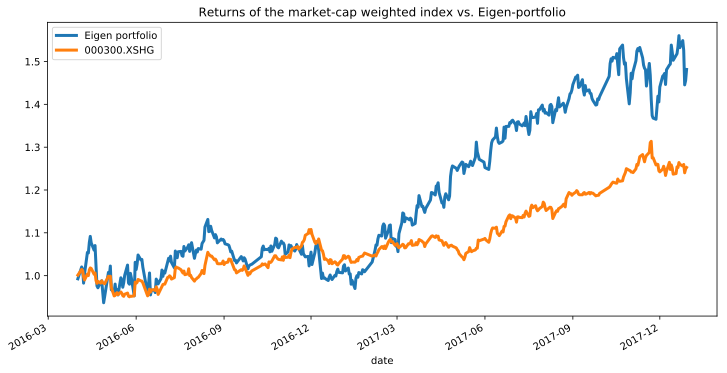

In [6]:
df_plot = pd.DataFrame({'Eigen portfolio': eigen_prtf_return, market_symbol: index_df[market_symbol].pct_change().dropna()
}, index=eigen_prtf_return.index)
np.cumprod(df_plot+1).plot(title='Returns of the market-cap weighted index vs. Eigen-portfolio', figsize=(12,6), linewidth=3)
plt.show()